In [ ]:
!pip install rouge_score
!pip install evaluate

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=897c6fc8a5039fd88cc791b64149acfe6c122e196587f2d2529487ed370195e0
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's depende

In [ ]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import evaluate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
huggingface_dataset_name = "joelniklaus/legal_case_document_summarization"
dataset = load_dataset(huggingface_dataset_name)
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.60k [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl.xz:   0%|          | 0.00/50.6M [00:00<?, ?B/s]

test.jsonl.xz:   0%|          | 0.00/2.30M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7773 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['judgement', 'dataset_name', 'summary'],
        num_rows: 7773
    })
    test: Dataset({
        features: ['judgement', 'dataset_name', 'summary'],
        num_rows: 200
    })
})

In [ ]:
dataset['test'][100]['judgement']

"This appeal was heard by this Panel on 10 and 11 February 2010.\nOn 14 April 2010, while we were still considering our decision upon it, we were asked to consider applications for permission to appeal in two other cases in which foreign national prisoners had been detained pending their deportation after completing their sentences of imprisonment.\nWalumba Lumba, a citizen of the Democratic Republic of Congo, sought permission to appeal from a decision of the Court of Appeal [2010] EWCA Civ 111, [2010] 1 WLR 2168, dismissing his appeal from a decision of Collins J [2008] EWHC 2090 (Admin) on his claim for judicial review to refuse him a declaration that his detention by the Secretary of State for the Home Department was unlawful, for a mandatory order for his release and for damages.\nMr Lumba together with Kadian Mighty, a citizen of Jamaica, also sought permission to appeal against the Court of Appeals decision dismissing their appeals from a decision of Davis J [2008] EWHC 3166 (Ad

In [ ]:
dataset['test'][100]['summary']

'The issue in this appeal is whether a failure by the Respondent to comply with a procedural requirement in its policy relating to the detention of foreign national prisoners results in their detention being unlawful, so as to allow the detainee to advance a claim in tort for false imprisonment.\nShepherd Masimba Kambadzi is a Zimbabwean national.\nHe entered the UK lawfully, but remained here after his leave to remain expired.\nIn 2005, he was convicted of assault and sexual assault, sentenced to one years imprisonment and ordered to be registered as a sex offender for five years.\nPrior to his being released from prison, the Respondent decided to make a deportation order against the Appellant.\nParagraph 2(2) of Schedule 3 to the Immigration Act 1971 (the 1971 Act) gives the Secretary of State the power to detain foreign nationals pending the making of a deportation order and the Appellant was detained under that power on 7 March 2006.\nOn 24 August 2007, a deportation order was made

In [ ]:
# View first 5 samples from each split
train_samples = dataset["train"].select(range(5))
test_samples = dataset["test"].select(range(5))
# Convert to DataFrame for better readability
df_train = pd.DataFrame(train_samples)
df_test = pd.DataFrame(test_samples)
# Display the data
print("🔹 Train Samples:")
display(df_train)
print("\n🔹 Test Samples:")
display(df_test)

🔹 Train Samples:


,judgement,dataset_name,summary
0,Appeal No. LXVI of 1949.\nAppeal from the High...,IN-Abs,The charge created in respect of municipal pro...
1,Civil Appeal No.94 of 1949.\n107 834 Appeal fr...,IN-Abs,"An agreement for a lease, which a lease is by ..."
2,"iminal Appeal No. 40 of 1951, 127 Appeal from ...",IN-Abs,"The question whether a Magistrate is ""personal..."
3,Appeal No. 388 of 1960.\nAppeal by special lea...,IN-Abs,The appellant was a member of a joint Hindu fa...
4,Appeal No. 198 of 1954.\nAppeal from the judgm...,IN-Abs,The appellant was the Ruler of the State of Ba...



🔹 Test Samples:


,judgement,dataset_name,summary
0,Appeal No. 101 of 1959.\nAppeal by special lea...,IN-Abs,The appellants who are displaced persons from ...
1,Appeal No. 52 of 1957.\nAppeal from the judgme...,IN-Abs,The appellants and the respondents were owners...
2,Appeals Nos. 45 and 46 of 1959.\nAppeal by spe...,IN-Abs,The respondents firm claimed exemption from Sa...
3,ION: Criminal Appeal 89 of 1961.\nAppeal by sp...,IN-Abs,The appellant was tried for murder.\nThe facts...
4,Civil Appeal No. 50 of 1961.\nAppeal by specia...,IN-Abs,"S, employed by the appellant as a cross cutter..."


In [ ]:
model_name='google/flan-t5-base'

original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [ ]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(original_model))

trainable model parameters: 247577856
all model parameters: 247577856
percentage of trainable model parameters: 100.00%


In [ ]:
index = 100
judgement = dataset['test'][index]['judgement']
summary = ' '.join(dataset['test'][index]['summary'].split()[:1000])

# Truncate judgement to first 1000 words
judgement_truncated = ' '.join(judgement.split()[:1000])

prompt = f"""
Summarize the following conversation.

{judgement_truncated}

Summary:
"""

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    original_model.generate(
        inputs["input_ids"],
        max_new_tokens=512,
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

Token indices sequence length is longer than the specified maximum sequence length for this model (1307 > 512). Running this sequence through the model will result in indexing errors


---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.

This appeal was heard by this Panel on 10 and 11 February 2010. On 14 April 2010, while we were still considering our decision upon it, we were asked to consider applications for permission to appeal in two other cases in which foreign national prisoners had been detained pending their deportation after completing their sentences of imprisonment. Walumba Lumba, a citizen of the Democratic Republic of Congo, sought permission to appeal from a decision of the Court of Appeal [2010] EWCA Civ 111, [2010] 1 WLR 2168, dismissing his appeal from a decision of Collins J [2008] EWHC 2090 (Admin) on his claim for judicial review to refuse him a declaration that his detention by the Secretary of State for the Home Department was unlawful, for a mandatory order for his release and for damages. Mr Lumba together with Kadian Mighty, a citizen of Ja

In [ ]:
def tokenize_function(example):
    start_prompt = 'Summarize the following conversation.\n\n'
    end_prompt = '\n\nSummary: '
    truncated_judgement = [
        ' '.join(j.split()[:1000]) for j in example["judgement"]
    ]
    prompt = [start_prompt + j + end_prompt for j in truncated_judgement]
    example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids
    example['labels'] = tokenizer(example["summary"], padding="max_length", truncation=True, return_tensors="pt").input_ids
    return example

# Apply tokenization
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['judgement', 'dataset_name', 'summary'])

Map:   0%|          | 0/7773 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_datasets.num_rows)

{'train': 7773, 'test': 200}


In [ ]:
print(f"Shapes of the datasets:")
print(f"Training: {tokenized_datasets['train'].shape}")
print(f"Test: {tokenized_datasets['test'].shape}")
print(tokenized_datasets)

Shapes of the datasets:
Training: (7773, 2)
Test: (200, 2)
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 7773
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 200
    })
})


In [ ]:
# View first 5 samples from each split
train_samples = tokenized_datasets["train"].select(range(5))
test_samples = tokenized_datasets["test"].select(range(5))

# Convert to DataFrame for better readability
df_train = pd.DataFrame(train_samples)
df_test = pd.DataFrame(test_samples)

# Display the data
print("🔹 Tokenized Train Samples:")
display(df_train)

print("\n🔹 Tokenized Test Samples:")
display(df_test)

🔹 Tokenized Train Samples:


,input_ids,labels
0,"[12198, 1635, 1737, 8, 826, 3634, 5, 25024, 46...","[37, 1567, 990, 16, 1445, 13, 10516, 785, 1104..."
1,"[12198, 1635, 1737, 8, 826, 3634, 5, 7707, 250...","[389, 2791, 21, 3, 9, 6841, 6, 84, 3, 9, 6841,..."
2,"[12198, 1635, 1737, 8, 826, 3634, 5, 256, 1027...","[37, 822, 823, 3, 9, 6611, 343, 2206, 19, 96, ..."
3,"[12198, 1635, 1737, 8, 826, 3634, 5, 25024, 46...","[37, 8319, 6761, 47, 3, 9, 1144, 13, 3, 9, 449..."
4,"[12198, 1635, 1737, 8, 826, 3634, 5, 25024, 46...","[37, 8319, 6761, 47, 8, 17104, 52, 13, 8, 1015..."



🔹 Tokenized Test Samples:


,input_ids,labels
0,"[12198, 1635, 1737, 8, 826, 3634, 5, 25024, 46...","[37, 8319, 6761, 7, 113, 33, 3, 27762, 7609, 4..."
1,"[12198, 1635, 1737, 8, 826, 3634, 5, 25024, 46...","[37, 8319, 6761, 7, 11, 8, 16467, 130, 2713, 1..."
2,"[12198, 1635, 1737, 8, 826, 3634, 5, 3, 29641,...","[37, 16467, 1669, 7760, 20554, 45, 7107, 5287,..."
3,"[12198, 1635, 1737, 8, 826, 3634, 5, 3, 9215, ...","[37, 8319, 6761, 47, 1971, 21, 7738, 5, 37, 66..."
4,"[12198, 1635, 1737, 8, 826, 3634, 5, 7707, 250...","[180, 6, 8152, 57, 8, 8319, 6761, 38, 3, 9, 22..."


In [ ]:
from peft import LoraConfig, get_peft_model, TaskType
lora_config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM
)

In [ ]:
peft_model = get_peft_model(original_model,
                            lora_config)
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 3538944
all model parameters: 251116800
percentage of trainable model parameters: 1.41%


In [ ]:
output_dir = f'/content/drive/MyDrive/LLM_learning/llm_training/training_backup/peft-dialogue-summary-training-{str(int(time.time()))}'

peft_training_args = TrainingArguments(
    output_dir=output_dir,
    auto_find_batch_size=True,
    learning_rate=1e-3,
    num_train_epochs=50,
    logging_steps=1,
    max_steps=100,
    report_to="none"
)

peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_datasets["train"],
)

No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
peft_trainer.train()

peft_model_path="/content/drive/MyDrive/LLM_learning/llm_training/training_backup/peft-dialogue-summary-checkpoint-local"

peft_trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
1,5.531200
2,7.937500
3,5.031200
4,2.843800
5,4.781200
6,4.906200
7,5.375000
8,5.000000
9,6.031200
10,3.109400


('/content/drive/MyDrive/LLM_learning/llm_training/training_backup/peft-dialogue-summary-checkpoint-local/tokenizer_config.json',
 '/content/drive/MyDrive/LLM_learning/llm_training/training_backup/peft-dialogue-summary-checkpoint-local/special_tokens_map.json',
 '/content/drive/MyDrive/LLM_learning/llm_training/training_backup/peft-dialogue-summary-checkpoint-local/spiece.model',
 '/content/drive/MyDrive/LLM_learning/llm_training/training_backup/peft-dialogue-summary-checkpoint-local/added_tokens.json',
 '/content/drive/MyDrive/LLM_learning/llm_training/training_backup/peft-dialogue-summary-checkpoint-local/tokenizer.json')

In [ ]:
from peft import PeftModel, PeftConfig

peft_model_base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base", torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

peft_model = PeftModel.from_pretrained(peft_model_base,
                                       '/content/drive/MyDrive/LLM_learning/llm_training/training_backup/peft-dialogue-summary-checkpoint-local/',
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False)

In [ ]:
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 0
all model parameters: 251116800
percentage of trainable model parameters: 0.00%


In [ ]:
# Set device (GPU if available, otherwise CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Move models to the same device
original_model.to(device)
peft_model.to(device)

index = 100
judgement = ' '.join(dataset["test"][index]["judgement"].split()[:1000])
baseline_human_summary = ' '.join(dataset["test"][index]["summary"].split()[:1000])
# Construct the prompt
prompt = f"""
Summarize the following conversation.

{judgement}

Summary: """

# Tokenize and move inputs to the same device as the models
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

# Generate summaries
original_model_outputs = original_model.generate(
    input_ids=input_ids,
    generation_config=GenerationConfig(max_new_tokens=512, num_beams=1),
)
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

peft_model_outputs = peft_model.generate(
    input_ids=input_ids,
    generation_config=GenerationConfig(max_new_tokens=512, num_beams=1),
)
peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

# Print results with proper formatting
dash_line = "-" * 50  # Define a separator line

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{baseline_human_summary}')
print(dash_line)
print(f'ORIGINAL MODEL:\n{original_model_text_output}')
print(dash_line)
print(f'PEFT MODEL:\n{peft_model_text_output}')
print(dash_line)

Token indices sequence length is longer than the specified maximum sequence length for this model (1307 > 512). Running this sequence through the model will result in indexing errors


--------------------------------------------------
BASELINE HUMAN SUMMARY:
The issue in this appeal is whether a failure by the Respondent to comply with a procedural requirement in its policy relating to the detention of foreign national prisoners results in their detention being unlawful, so as to allow the detainee to advance a claim in tort for false imprisonment. Shepherd Masimba Kambadzi is a Zimbabwean national. He entered the UK lawfully, but remained here after his leave to remain expired. In 2005, he was convicted of assault and sexual assault, sentenced to one years imprisonment and ordered to be registered as a sex offender for five years. Prior to his being released from prison, the Respondent decided to make a deportation order against the Appellant. Paragraph 2(2) of Schedule 3 to the Immigration Act 1971 (the 1971 Act) gives the Secretary of State the power to detain foreign nationals pending the making of a deportation order and the Appellant was detained under that po

In [ ]:
dataset['test'][100]['judgement']

"This appeal was heard by this Panel on 10 and 11 February 2010.\nOn 14 April 2010, while we were still considering our decision upon it, we were asked to consider applications for permission to appeal in two other cases in which foreign national prisoners had been detained pending their deportation after completing their sentences of imprisonment.\nWalumba Lumba, a citizen of the Democratic Republic of Congo, sought permission to appeal from a decision of the Court of Appeal [2010] EWCA Civ 111, [2010] 1 WLR 2168, dismissing his appeal from a decision of Collins J [2008] EWHC 2090 (Admin) on his claim for judicial review to refuse him a declaration that his detention by the Secretary of State for the Home Department was unlawful, for a mandatory order for his release and for damages.\nMr Lumba together with Kadian Mighty, a citizen of Jamaica, also sought permission to appeal against the Court of Appeals decision dismissing their appeals from a decision of Davis J [2008] EWHC 3166 (Ad

In [ ]:
dataset['test'][100]['summary']

'The issue in this appeal is whether a failure by the Respondent to comply with a procedural requirement in its policy relating to the detention of foreign national prisoners results in their detention being unlawful, so as to allow the detainee to advance a claim in tort for false imprisonment.\nShepherd Masimba Kambadzi is a Zimbabwean national.\nHe entered the UK lawfully, but remained here after his leave to remain expired.\nIn 2005, he was convicted of assault and sexual assault, sentenced to one years imprisonment and ordered to be registered as a sex offender for five years.\nPrior to his being released from prison, the Respondent decided to make a deportation order against the Appellant.\nParagraph 2(2) of Schedule 3 to the Immigration Act 1971 (the 1971 Act) gives the Secretary of State the power to detain foreign nationals pending the making of a deportation order and the Appellant was detained under that power on 7 March 2006.\nOn 24 August 2007, a deportation order was made

In [ ]:
from tqdm import tqdm  # import tqdm

judgements = [' '.join(j.split()[:1000]) for j in dataset['test'][0:10]['judgement']]
human_baseline_summaries = [' '.join(s.split()[:1000]) for s in dataset['test'][0:10]['summary']]

original_model_summaries = []
peft_model_summaries = []

# Move models to GPU
original_model.to("cuda")
peft_model.to("cuda")

# Add tqdm for progress tracking
for idx, judgement in tqdm(enumerate(judgements), total=len(judgements), desc="Generating Summaries"):
    prompt = f"""
    Summarize the following conversation.

    {judgement}

    Summary: """

    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")  # Move to GPU

    original_model_outputs = original_model.generate(
        input_ids=input_ids,
        generation_config=GenerationConfig(max_new_tokens=512)
    )
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

    peft_model_outputs = peft_model.generate(
        input_ids=input_ids,
        generation_config=GenerationConfig(max_new_tokens=512)
    )
    peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

    original_model_summaries.append(original_model_text_output)
    peft_model_summaries.append(peft_model_text_output)

# Create DataFrame
df = pd.DataFrame({
    'human_baseline_summaries': human_baseline_summaries,
    'original_model_summaries': original_model_summaries,
    'peft_model_summaries': peft_model_summaries
})
df

Generating Summaries: 100%|██████████| 10/10 [05:18<00:00, 31.84s/it]


,human_baseline_summaries,original_model_summaries,peft_model_summaries
0,The appellants who are displaced persons from ...,"Alleghendal vs. State of Punjab, Appellants ap...",The appellants were granted quasi permanent al...
1,The appellants and the respondents were owners...,"On June 15, 1900, Raja Durga Prasad Singh exec...","On August 2, 1,894, Raja of Jharia granted muk..."
2,The respondents firm claimed exemption from Sa...,The sellers alleged that they sold cotton and ...,The sellers argued that the goods were sold on...
3,The appellant was tried for murder. The facts ...,The appellant alleged that he had murdered She...,"The appellant, G. C. Mathur and C. P. Lal, app..."
4,"S, employed by the appellant as a cross cutter...","In a case of a resigning of a workman, the app...",The appellant in a saw mill carrying on busine...
5,"The appellant, a postman, and I,is father were...",The appellant was a trade union official who w...,The appellant was a trade union official attac...
6,Sub section (1) of section 24B of the Indian I...,The appellant was the heirs and legal represen...,The appellant was the heirs and legal represen...
7,"By section 25 (4) of the Income tax Act, ""Wher...",The appellant had transferred its business to ...,The appellant claimed relief under section 25(...
8,"In 1947, the Dholpur State acceded to the Domi...","Relatives of the respondent, who had a valid e...",The respondent was a resident of the former Dh...
9,In pursuance of an award made by an Industrial...,"The appellant, in the first appeal, argues tha...",The appellant challenged the authority that th...


In [ ]:
print("human_baseline_summaries:", df['human_baseline_summaries'][0])
print('-'*50)
print("original_model_summaries:", df['original_model_summaries'][0])
print('-'*50)
print("peft_model_summaries:", df['peft_model_summaries'][0])

human_baseline_summaries: The appellants who are displaced persons from West Pakistan, were granted quasi permanent allotment of some lands in village Raikot in 1949. On October 31, 1952, the Assistant Custodian cancelled the allotment of 14 allottees in village Karodian, and also cancelled the allotment of the Appellants in Raikot but allotted lands to them in village Karodian, and allotted the lands of Raikot to other persons. The 14 allottees of village Karodian as well as the appellants applied for review of the orders of cancellation of their allotment. The application of the 14 allottees was dismissed. They preferred a revision to the Custodian General who cancelled the appellant 's allotment (1) Cal. 926. 329 in Karodian and restored the allotment of the 14 allottees on December 17, 1954 Thereupon,, on January 6, 1955, the appellants moved the Custodian General for calling up their review application and for revising the order of October 31, 1952, cancelling their allotment in R

In [ ]:
rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('PEFT MODEL:')
print(peft_model_results)

ORIGINAL MODEL:
{'rouge1': np.float64(0.2638731972853877), 'rouge2': np.float64(0.07067991920547151), 'rougeL': np.float64(0.20140693844755153), 'rougeLsum': np.float64(0.2011440230724724)}
PEFT MODEL:
{'rouge1': np.float64(0.35056206320407335), 'rouge2': np.float64(0.0997187710137264), 'rougeL': np.float64(0.21350475532488097), 'rougeLsum': np.float64(0.2133330967175778)}


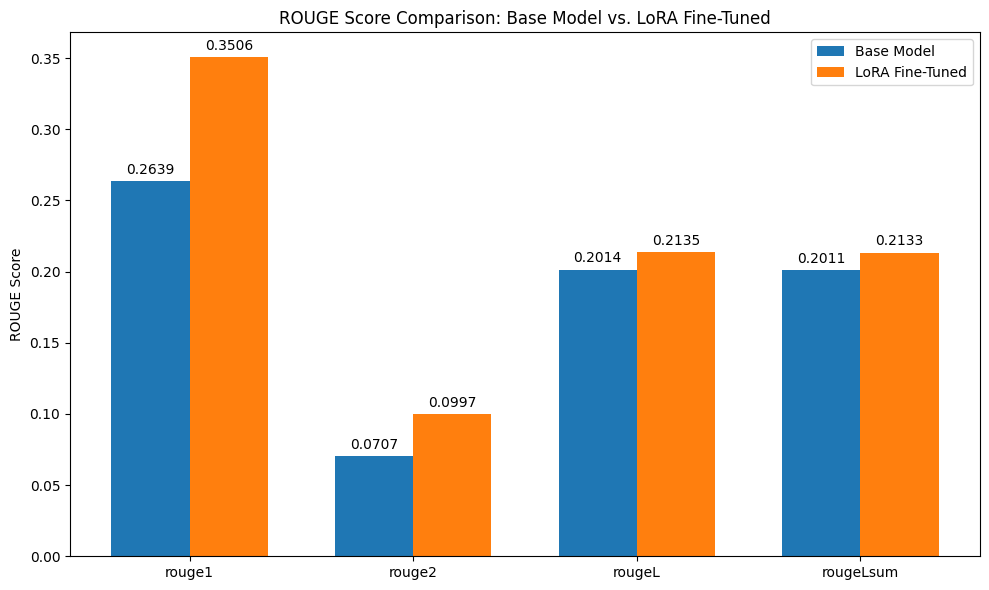

In [ ]:
labels = list(original_model_results.keys())
base_scores = list(original_model_results.values())
lora_scores = list(peft_model_results.values())

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, base_scores, width, label='Base Model')
bars2 = ax.bar(x + width/2, lora_scores, width, label='LoRA Fine-Tuned')

# Add labels, title, legend
ax.set_ylabel('ROUGE Score')
ax.set_title('ROUGE Score Comparison: Base Model vs. LoRA Fine-Tuned')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add text labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()

In [ ]:
# Set device (GPU if available, otherwise CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Move models to the same device
original_model.to(device)
peft_model.to(device)

# Input judgment (manually provided for testing)
judgement_text = """
The trial court improperly instructed the jury that it should not consider
the victim's delayed reporting when evaluating her credibility because,
although the court's instruction was proper at the time that it was given,
the Supreme Court's subsequent decision in State v. Adam P. (351 Conn.
213), which was released while the defendant’s appeal was pending before
this court, reinstated the standard, articulated in State v. Troupe, (237 Conn.
284), that a defendant in a sexual assault case is entitled to an instruction
that any delay by the victim in reporting the incident is a matter for the
jury to consider in evaluating the weight of the victim's testimony.
"""

# Construct the prompt
prompt = f"""
Summarize the following conversation.

{judgement_text}

Summary:
"""

# Tokenize and move inputs to the same device as the models
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

# Generate summaries
original_model_outputs = original_model.generate(
    input_ids=input_ids,
    generation_config=GenerationConfig(max_new_tokens=512, num_beams=1),
)
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

peft_model_outputs = peft_model.generate(
    input_ids=input_ids,
    generation_config=GenerationConfig(max_new_tokens=512, num_beams=1),
)
peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

# Print results
dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'ORIGINAL MODEL:\n{original_model_text_output}')
print(dash_line)
print(f'PEFT MODEL:\n{peft_model_text_output}')
print(dash_line)

---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.


The trial court improperly instructed the jury that it should not consider
the victim's delayed reporting when evaluating her credibility because,
although the court's instruction was proper at the time that it was given,
the Supreme Court's subsequent decision in State v. Adam P. (351 Conn.
213), which was released while the defendant’s appeal was pending before
this court, reinstated the standard, articulated in State v. Troupe, (237 Conn.
284), that a defendant in a sexual assault case is entitled to an instruction
that any delay by the victim in reporting the incident is a matter for the
jury to consider in evaluating the weight of the victim's testimony.


Summary:

---------------------------------------------------------------------------------------------------
ORIGINAL MODEL:
The jury court improperly instructed the jury tha